# Segment Anything - Experiments
We believe that the abilities of the released foundation model, **Segment Anything Model** (*SAM*), can serve the purpose of creating a *generalizable object-centric representation* model. Indeed, its capacity to segment any object into images in a zero-shot manner would permit to serve as a powerful prior for object discovery.

That's why we want to experiment with it, to see how we can leverage its knowledge to train new models through *knowledge distillation* later on.

## Import librairies

In [1]:
# Import all the packages needed for the project 
from segment_anything import SamAutomaticMaskGenerator, SamPredictor, sam_model_registry
from expe.dataset import YCBDataset, ARMDataset, GUIMODDataset
from torch.utils.data import DataLoader
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import sys

using_colab = False

## Utility functions
We first define some utility functions to visualize the masks, points and boxes around objects.

In [2]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))   
    
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    polygons = []
    color = []
    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]
        ax.imshow(np.dstack((img, m*0.35)))

## Load model
Three different size of checkpoints are available for the model. In our experiments, we will use the default size (ViT-H). 

In [3]:
sys.path.append("..")

device = "cuda"
sam = sam_model_registry["default"](checkpoint="sam_vit_h_4b8939.pth")
sam.to(device=device)

print()

## Create the datasets
For our experiments, we will test the abilities of *SAM* on several real world objects dataset. This could permit us to confirm if it could be correctly used to be deployed in such a scenario. 

The **YCB-Video** dataset used for 6D pose estimation seems to be a good starting point to evaluate the *zero-shot segmentation capabilities* of the model. It is compose of thousands of images containing 21 different objects in 80 different scenes with different viewpoints.

The **ARMBench** dataset is a perception and manipulation benchmark in a robotic pick-and-place setting. It contains several scenes with different objects and different challenges such as Object segmentation, Object Identification, and Defect Detection on images and videos.

The **GUIMOD** dataset is our dataset which is compose of bin picking scene with fruits. 

To handle the data from these datasets, we created custom Pytorch Dataset classes. 

In [4]:
#dataset_ycb = YCBDataset("./../../Datasets/ycb-video/image_sets/train.txt", "./../../Datasets/ycb-video/data")
#dataloader_ycb = DataLoader(dataset, batch_size=16, shuffle=True)

dataset_arm = ARMDataset("./../Datasets/ARMBench/images.txt", "./../Datasets/ARMBench/")
dataloader_arm = DataLoader(dataset_arm, batch_size=1, shuffle=False)

## Prompts discovery
In this section, we will do some visualization to study the data and see how the model is working with simple prompts

### Show images
We first show some random images to see how they look.

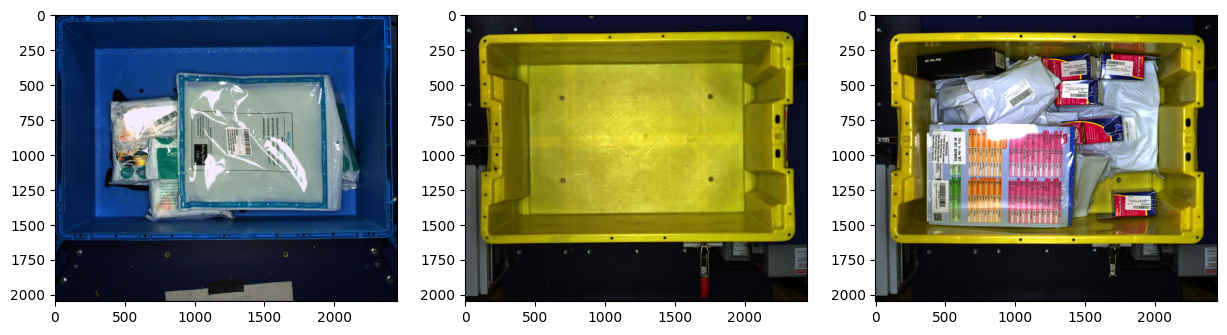

In [39]:
# Show the first images of ARMBench
i = 1
fig = plt.figure(figsize=(15,15))
for image in dataset_arm:
    img = image
    fig.add_subplot(2, 3, i)
    plt.imshow(img)
    if i > 2:
        break
    i+=1
plt.show() 


### Predict masks with points
In the following section, we will see the ability of *SAM* to segment objects with a Point prompt.

A Point prompt is in the format (x, y) and is given with a label 1 (for foreground) and 0 (for background).

We will show what the model predicts for a given prompt. The `multimask_output=True` setting outputs 3 masks, with a `scores` estimation of the quality of these masks. It could permit to get multiple ambiguous masks and then select the one with the best score.


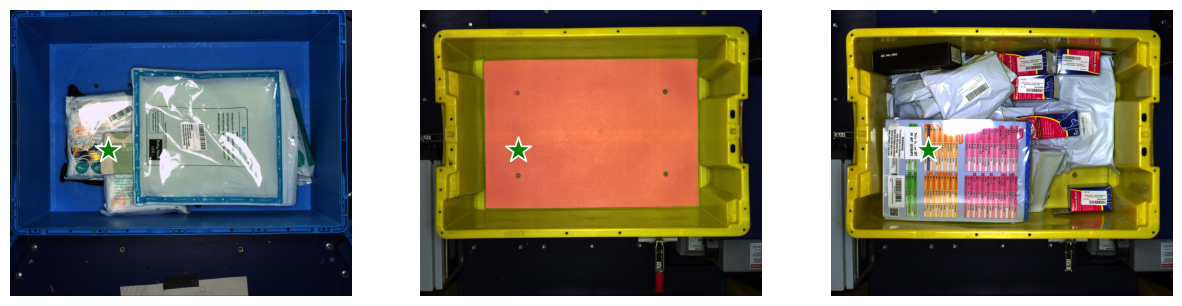

In [43]:
# Prompt point and label
input_point = np.array([[700, 1000]])
input_label = np.array([1])

i = 1
fig = plt.figure(figsize=(15,15))

# Defining a predictor
predictor = SamPredictor(sam)

# Predict the masks
for image in dataset_arm:
    img = np.array(image)
    predictor.set_image(img) # Predict the masks given an image and the point
    masks, scores, logits = predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        multimask_output=True,
    )
    # Show the best mask predicted and print its score
    id_mask = np.argmax(scores)
    fig.add_subplot(1, 3, i)
    plt.imshow(img) 
    show_mask(masks[id_mask], plt.gca(), True)
    show_points(input_point, input_label, plt.gca())
    plt.axis('off')
    if i > 2:
        break
    i+=1
plt.show() 

We can also use multiple points to handle a single object like in the following. With `multimask_output=False`, we tell the predictor that only one mask should be outputed (and that there is no ambiguity) :

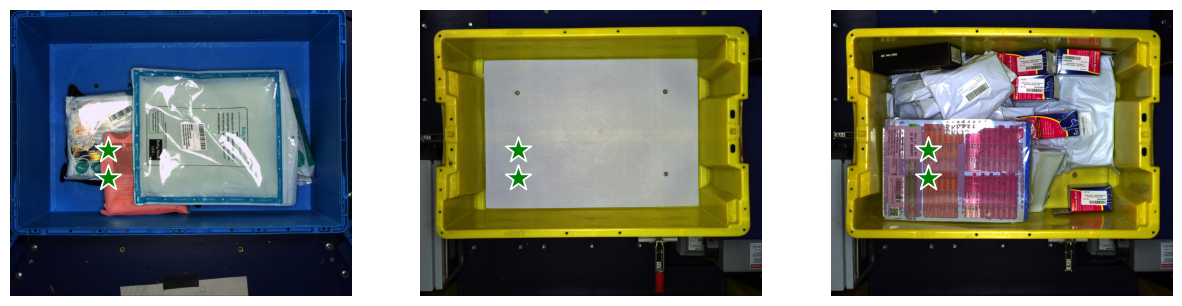

In [42]:
# New points and label prompt
input_point = np.array([[700, 1000], [700, 1200]])
input_label = np.array([1, 1])

i = 1
fig = plt.figure(figsize=(15,15))

# Predict the masks
for image in dataset_arm:
    img = np.array(image)
    predictor.set_image(img) # Predict the masks given an image and the point
    masks, scores, logits = predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        multimask_output=True,
    )
    # Show the best mask predicted and print its score
    id_mask = np.argmax(scores)
    fig.add_subplot(1, 3, i)
    plt.imshow(img) 
    show_mask(masks[id_mask], plt.gca(), True)
    show_points(input_point, input_label, plt.gca())
    plt.axis('off')
    if i > 2:
        break
    i+=1
plt.show()

There also exist negative points that permits to exclude some parts from the segmentation. To do that, the negative point should be marked as a background point. 

### Predict mask with box
In the following, we will see how *SAM* segment objects with a box prompt. 

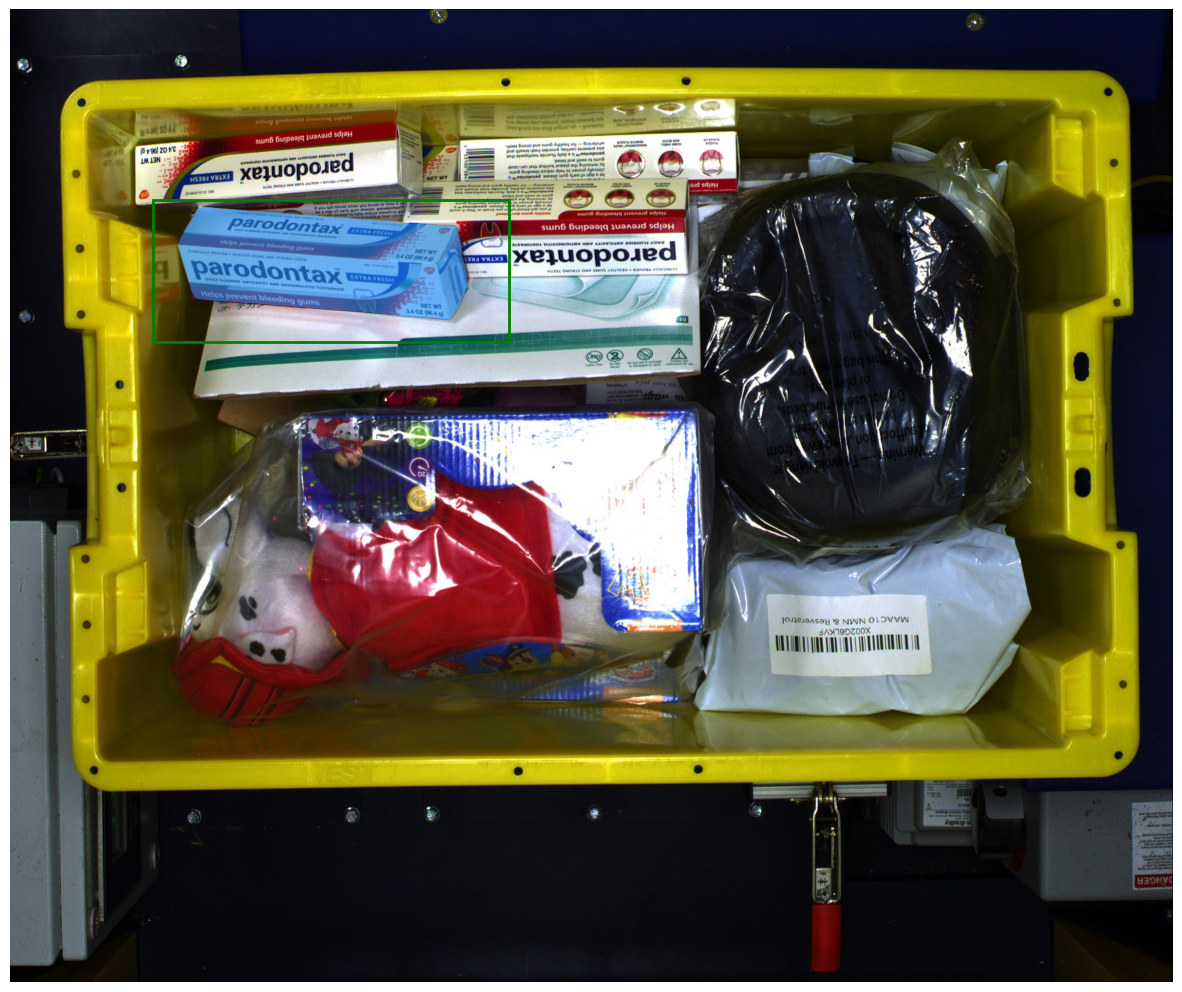

In [38]:
input_box = np.array([300, 400, 1050, 700])

# Predict the mask by removing the part of the Point
img = np.array(dataset_arm[5])
predictor.set_image(img) # Predict the masks given an image and the mask
masks, _, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box,
    multimask_output=False,
)
plt.figure(figsize=(15,15))
plt.imshow(img) 
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
plt.axis('off')
plt.show()

## Mask prediction without prompt
In the following section, we will test the ability of the *SAM* model to detect by itself in a *zero-shot* manner the mask of the objects into any images of the studied dataset. *SAM* can process prompts efficiently, thus masks for the entire image can be generated by sampling a large number of prompts. The class `SamAutomaticMaskGenerator` implements this capability. It works by sampling single-point input prompts in a grid over the image, from each of which SAM can predict multiple masks. Then, masks are filtered for quality and deduplicated using non-maximal suppression. Additional options allow for further improvement of mask quality and quantity, such as running prediction on multiple crops of the image or postprocessing masks to remove small disconnected regions and holes.

This would permit later on to extract a hierarchy of mask inside an image.

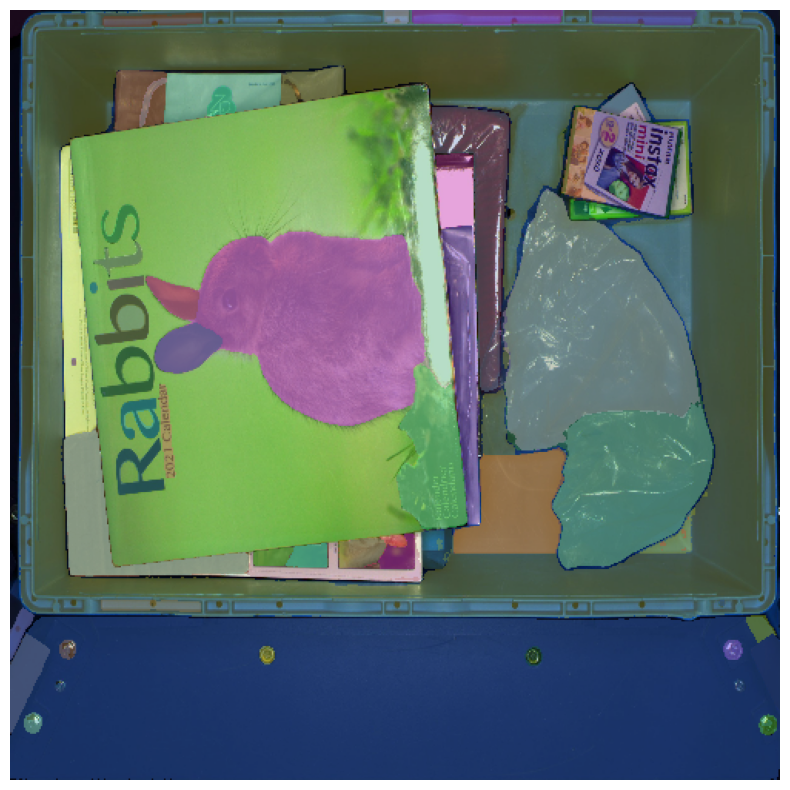

In [16]:
# Defining a mask generator
mask_generator = SamAutomaticMaskGenerator(sam)

# Predict the masks from one image
image = dataset_arm[10]
image = cv2.resize(image, (500, 500))
masks = mask_generator.generate(image)
plt.figure(figsize=(10,10))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 

Several parameters can be tuned to control the density of points on the image (to have more fine-grained decomposition as an example), a threshold to remove low quality or duplicated masks. Here for example, we use less points to process the image and we can see that there is less decomposition on the image. 

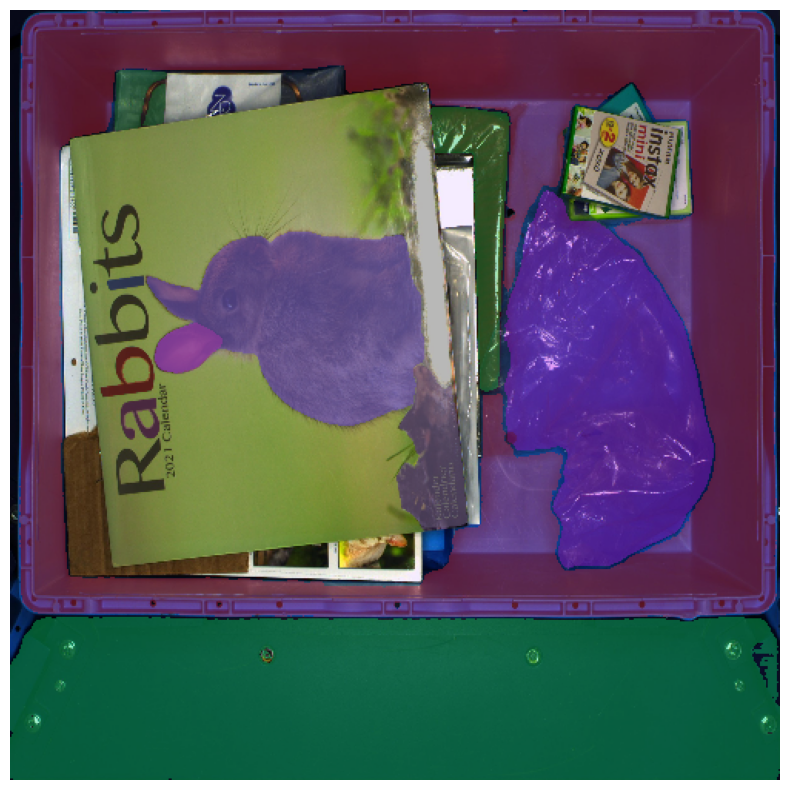

In [17]:
mask_generator_2 = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=10
)

masks2 = mask_generator_2.generate(image)
plt.figure(figsize=(10,10))
plt.imshow(image)
show_anns(masks2)
plt.axis('off')
plt.show() 

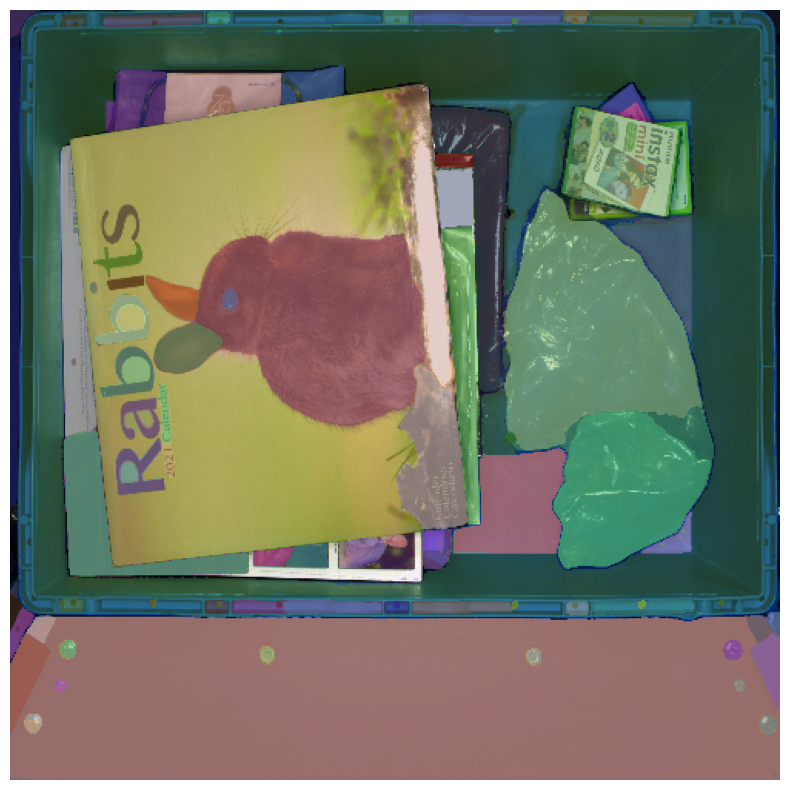

In [20]:
mask_generator_3 = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=60
)

masks3 = mask_generator_3.generate(image)
plt.figure(figsize=(10,10))
plt.imshow(image)
show_anns(masks3)
plt.axis('off')
plt.show() 

Parameters for the automatic mask detection:

`model (Sam)`: The SAM model to use for mask prediction. 

`points_per_side = 32`: The number of points to be sampled along one side of the image. The total number of points is 2 \* image_size. If None, must provide `point_grids`.

`points_per_batch = 64`: Sets the number of points run simultaneously by the model. Higher numbers may be faster but use more GPU memory.

`pred_iou_thresh = 0.88`: A filtering threshold in [0,1], using the model's predicted mask quality.

`stability_score_thresh = 0.95`: A filtering threshold in [0,1], using the stability of the mask under changes to the cutoff used to binarize the model's mask predictions.

`stability_score_offset 1.0`: The amount to shift the cutoff when calculated the stability score.

`box_nms_thresh = 0.7`: The box IoU cutoff used by non-maximal suppression to filter duplicate masks.


`crop_n_layers = 0`: If >0, mask prediction will be run again on crops of the image. Sets the number of layers to run.

`crop_nms_thresh = 0.7`: The box IoU cutoff used by non-maximal suppression to filter duplicate masks between different crops.

`crop_overlap_ratio = 512 / 1500`: Sets the degree to which crops overlap. In the first crop layer, crops will overlap by this fraction of the image length. Later layers with more crops scale down this overlap.

`crop_n_points_downscale_factor = 1`: The number of points-per-side sampled in layer n is scaled down by crop_n_points_downscale_factor \* n.

`point_grids = None`: A list over explicit grids of points used for sampling, normalized to [0,1]. The nth grid in the list is used in the nth crop layer. Exclusive with points_per_side.

`min_mask_region_area = 0`: If >0, postprocessing will be applied to remove disconnected regions and holes in masks with area smaller than min_mask_region_area. Requires opencv.

`output_mode = "binary_mask"`: The form masks are returned in. Can be 'binary_mask', 'uncompressed_rle', or 'coco_rle'. 'coco_rle' requires pycocotools. For large resolutions, 'binary_mask' may consume large amounts of memory.

## Experimentations

### GUIMOD

### ARMBench

### YCB-Video

## YOLO with SAM
We will now try to combine the YOLOv8 model, pre-trained on the given dataset in order to detect objects on the image to then check the segmentation obtained. We will compare the results with ground-truth values. 